<a href="https://colab.research.google.com/github/jihyeon602/ETRI_lifelog_dataset/blob/main/%EC%88%98%EB%A9%B4%EC%98%88%EC%B8%A1_TEST3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이콘 수면예측 경진대회
##베이스라인

In [1]:
import numpy as np
import pandas as pd
import glob
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [2]:
# seed 고정
SD = 42
random.seed(SD)
np.random.seed(SD)
os.environ['PYTHONHASHSEED'] = str(SD)

## 데이터 로드

In [ ]:
#ZIP 파일 열기
import zipfile
with zipfile.ZipFile('/content/ETRI_lifelog_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ETRI')

In [5]:
import zipfile
with zipfile.ZipFile('/content/ETRI/ch2025_data_items.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ETRI/ch2025_data_items')

In [6]:
# 파일 경로 설정
data_dir = '/content/ETRI/ch2025_data_items'

# Parquet 파일 전체 경로 리스트
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet'))

In [7]:
# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리
lifelog_data = {}

# 파일별로 읽기
for file_path in parquet_files:
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '')
    lifelog_data[name] = pd.read_parquet(file_path)
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}")

✅ Loaded: wPedo, shape = (748100, 9)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: mActivity, shape = (961062, 3)


In [8]:
# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당
for key, df in lifelog_data.items():
    globals()[f"{key}_df"] = df

In [9]:
# lifelog_date가 timestamp랑 같다
metrics_train = pd.read_csv('/content/ETRI/ch2025_metrics_train.csv')
sample_submission = pd.read_csv('/content/ETRI/ch2025_submission_sample.csv')

In [10]:
sample_submission

,subject_id,sleep_date,lifelog_date,Q1,Q2,Q3,S1,S2,S3
0,id01,2024-07-31,2024-07-30,0,0,0,0,0,0
1,id01,2024-08-01,2024-07-31,0,0,0,0,0,0
2,id01,2024-08-02,2024-08-01,0,0,0,0,0,0
3,id01,2024-08-03,2024-08-02,0,0,0,0,0,0
4,id01,2024-08-04,2024-08-03,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
245,id10,2024-09-22,2024-09-21,0,0,0,0,0,0
246,id10,2024-09-23,2024-09-22,0,0,0,0,0,0
247,id10,2024-09-25,2024-09-24,0,0,0,0,0,0
248,id10,2024-09-26,2024-09-25,0,0,0,0,0,0


In [11]:
# ✅ 기준 쌍 (subject_id, lifelog_date)
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date'])
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date))

# ✅ DataFrame 별 timestamp 컬럼 수동 지정
dataframes = {
    'mACStatus': (mACStatus_df, 'timestamp'),
    'mActivity': (mActivity_df, 'timestamp'),
    'mAmbience': (mAmbience_df, 'timestamp'),
    'mBle': (mBle_df, 'timestamp'),
    'mGps': (mGps_df, 'timestamp'),
    'mLight': (mLight_df, 'timestamp'),
    'mScreenStatus': (mScreenStatus_df, 'timestamp'),
    'mUsageStats': (mUsageStats_df, 'timestamp'),
    'mWifi': (mWifi_df, 'timestamp'),
    'wHr': (wHr_df, 'timestamp'),
    'wLight': (wLight_df, 'timestamp'),
    'wPedo': (wPedo_df, 'timestamp'),
}

# ✅ 분리 함수
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'):
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df = df.dropna(subset=[timestamp_col])
    df['date_only'] = df[timestamp_col].dt.date
    df['key'] = list(zip(df[subject_col], df['date_only']))

    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key'])
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key'])
    return test_df, train_df

# ✅ 결과 저장
for name, (df, ts_col) in dataframes.items():
    print(f"⏳ {name} 분리 중...")
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col)
    globals()[f"{name}_test"] = test_df
    globals()[f"{name}_train"] = train_df
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}")

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


In [12]:
print("✅ sample_submission shape:", sample_submission.shape)
print("✅ test_keys 개수:", len(test_keys))

for name, (df, ts_col) in dataframes.items():
    print(f"\n🔍 {name} 체크")
    print("컬럼들:", df.columns.tolist())
    print("subject_id null 갯수:", df['subject_id'].isnull().sum())
    print(f"{ts_col} null 갯수:", df[ts_col].isnull().sum())
    print(f"{name} DataFrame 크기:", df.shape)


✅ sample_submission shape: (250, 9)
✅ test_keys 개수: 250

🔍 mACStatus 체크
컬럼들: ['subject_id', 'timestamp', 'm_charging']
subject_id null 갯수: 0
timestamp null 갯수: 0
mACStatus DataFrame 크기: (939896, 3)

🔍 mActivity 체크
컬럼들: ['subject_id', 'timestamp', 'm_activity']
subject_id null 갯수: 0
timestamp null 갯수: 0
mActivity DataFrame 크기: (961062, 3)

🔍 mAmbience 체크
컬럼들: ['subject_id', 'timestamp', 'm_ambience']
subject_id null 갯수: 0
timestamp null 갯수: 0
mAmbience DataFrame 크기: (476577, 3)

🔍 mBle 체크
컬럼들: ['subject_id', 'timestamp', 'm_ble']
subject_id null 갯수: 0
timestamp null 갯수: 0
mBle DataFrame 크기: (21830, 3)

🔍 mGps 체크
컬럼들: ['subject_id', 'timestamp', 'm_gps']
subject_id null 갯수: 0
timestamp null 갯수: 0
mGps DataFrame 크기: (800611, 3)

🔍 mLight 체크
컬럼들: ['subject_id', 'timestamp', 'm_light']
subject_id null 갯수: 0
timestamp null 갯수: 0
mLight DataFrame 크기: (96258, 3)

🔍 mScreenStatus 체크
컬럼들: ['subject_id', 'timestamp', 'm_screen_use']
subject_id null 갯수: 0
timestamp null 갯수: 0
mScreenStatus DataFra

## 분단위 -> 하루 단위 변환함수(def)
### 1. mACStatus

In [13]:
def process_mACStatus(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df = df.sort_values(['subject_id', 'timestamp'])

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        status = group['m_charging'].values  # 0/1 상태
        times = group['timestamp'].values

        # 충전 상태 비율
        ratio_charging = status.mean()

        # 상태 전이 횟수
        transitions = (status[1:] != status[:-1]).sum()

        # 연속된 1 상태 길이들
        lengths = []
        current_len = 0
        for val in status:
            if val == 1:
                current_len += 1
            elif current_len > 0:
                lengths.append(current_len)
                current_len = 0
        if current_len > 0:
            lengths.append(current_len)

        avg_charging_duration = np.mean(lengths) if lengths else 0
        max_charging_duration = np.max(lengths) if lengths else 0

        results.append({
            'subject_id': subj,
            'date': date,
            'charging_ratio': ratio_charging,
            'charging_transitions': transitions,
            'avg_charging_duration': avg_charging_duration,
            'max_charging_duration': max_charging_duration,
        })

    return pd.DataFrame(results)

#변환
mACStatus_df2 = process_mACStatus(mACStatus_df)

In [17]:
mACStatus_df.head(3)

,subject_id,timestamp,m_charging,date
0,id01,2024-06-26 12:03:00,0,2024-06-26
1,id01,2024-06-26 12:04:00,0,2024-06-26
2,id01,2024-06-26 12:05:00,0,2024-06-26


In [16]:
mACStatus_df2.head(13)

,subject_id,date,charging_ratio,charging_transitions,avg_charging_duration,max_charging_duration
0,id01,2024-06-26,0.215859,22,13.363636,41
1,id01,2024-06-27,0.158571,32,13.875000,65
2,id01,2024-06-28,0.180282,29,17.066667,76
3,id01,2024-06-29,0.286567,3,192.000000,328
4,id01,2024-06-30,0.144286,8,50.500000,91
5,id01,2024-07-01,0.167742,48,9.750000,54
6,id01,2024-07-02,0.184615,37,13.894737,46
7,id01,2024-07-03,0.264029,51,14.115385,178
8,id01,2024-07-04,0.151049,14,30.857143,51
9,id01,2024-07-05,0.181951,32,15.625000,61


### 2. mActivity
- 0: IN_VEHICLE(차량 탑승)
- 1: ON_BICYCLE(자전거 탑승)
- 2: ON_FOOT(이동중)
- 3: STILL(정지)
- 4: UNKNOWN(알수없음)
- 5: TILTING(기울임, 각도 변경)
- 6: ??
- 7: WALKING(보행중)
- 8: RUNNING(뛰는중)

In [18]:
def process_mActivity(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    summary = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        counts = group['m_activity'].value_counts(normalize=True)  # 비율
        row = {'subject_id': subj, 'date': date}

        # 0~8 비율 저장
        for i in range(9):
            row[f'activity_{i}_ratio'] = counts.get(i, 0)

        # 주요 활동 정보
        row['dominant_activity'] = group['m_activity'].mode()[0]
        row['num_unique_activities'] = group['m_activity'].nunique()

        summary.append(row)

    return pd.DataFrame(summary)

mActivity_df2 = process_mActivity(mActivity_df)

In [20]:
mActivity_df.head(3)

,subject_id,timestamp,m_activity,date
0,id01,2024-06-26 12:03:00,4,2024-06-26
1,id01,2024-06-26 12:04:00,0,2024-06-26
2,id01,2024-06-26 12:05:00,0,2024-06-26


In [21]:
mActivity_df2.head(5)

,subject_id,date,activity_0_ratio,activity_1_ratio,activity_2_ratio,activity_3_ratio,activity_4_ratio,activity_5_ratio,activity_6_ratio,activity_7_ratio,activity_8_ratio,dominant_activity,num_unique_activities
0,id01,2024-06-26,0.125176,0.001406,0,0.672293,0.157525,0,0,0.043601,0.0,3,5
1,id01,2024-06-27,0.146528,0.000000,0,0.611111,0.220833,0,0,0.021528,0.0,3,4
2,id01,2024-06-28,0.111806,0.000694,0,0.861806,0.000694,0,0,0.025000,0.0,3,5
3,id01,2024-06-29,0.065972,0.000000,0,0.916667,0.000000,0,0,0.017361,0.0,3,3
4,id01,2024-06-30,0.138194,0.000000,0,0.853472,0.000000,0,0,0.008333,0.0,3,3


### 3. mAmbience
- 10개 라벨 지정해서 하루단위 평균값으로 요약

In [22]:
# 지정된 10개 라벨
top_10_labels = [
    "Inside, small room", "Speech", "Silence", "Music",
    "Narration, monologue", "Child speech, kid speaking",
    "Conversation", "Speech synthesizer", "Shout", "Babbling"
]

#지정 라벨만 남기기
def process_mAmbience_top10(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    # 초기화
    for label in top_10_labels + ['others']:
        df[label] = 0.0

    for idx, row in df.iterrows():
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience']
        others_prob = 0.0

        for label, prob in parsed:
            prob = float(prob)
            if label in top_10_labels:
                df.at[idx, label] = prob
            else:
                others_prob += prob

        df.at[idx, 'others'] = others_prob

    return df.drop(columns=['m_ambience'])

mAmbience_df2= process_mAmbience_top10(mAmbience_df)

def summarize_mAmbience_daily(df):
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']]

    # 하루 단위로 평균값 요약
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index()
    return daily_summary

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2)

In [23]:
mAmbience_df.head(5)

,subject_id,timestamp,m_ambience
0,id01,2024-06-26 13:00:10,"[[Music, 0.30902618], [Vehicle, 0.081680894], ..."
1,id01,2024-06-26 13:02:10,"[[Music, 0.62307084], [Vehicle, 0.021118319], ..."
2,id01,2024-06-26 13:04:10,"[[Horse, 0.25209898], [Animal, 0.24263993], [C..."
3,id01,2024-06-26 13:06:10,"[[Speech, 0.93433166], [Inside, large room or ..."
4,id01,2024-06-26 13:08:10,"[[Speech, 0.8935082], [Inside, small room, 0.0..."


In [24]:
mAmbience_df2.head(5)

,subject_id,date,"Inside, small room",Speech,Silence,Music,"Narration, monologue","Child speech, kid speaking",Conversation,Speech synthesizer,Shout,Babbling,others
0,id01,2024-06-26,2.183661e-02,2.466539e-01,0.116573,3.041167e-02,1.807150e-03,0.000645,0.000919,0.000033,0.000639,0.0,0.500729
1,id01,2024-06-27,5.669892e-05,8.622866e-08,0.998611,7.056701e-15,9.689560e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.001542
2,id01,2024-06-28,1.019045e-05,1.434175e-03,0.995774,7.036657e-15,2.030282e-05,0.000002,0.000002,0.000005,0.000000,0.0,0.003555
3,id01,2024-06-29,3.832783e-04,8.622867e-08,0.998611,7.056701e-15,9.689562e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.002089
4,id01,2024-06-30,2.072503e-27,8.622866e-08,0.998685,7.056702e-15,9.689561e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.000934


### 4. mBle
- 신호데이터 가공
- process_mBle(df): row-by-row(한 행씩) BLE 데이터 해석해서 feature를 뽑는 함수
- summarize_mBle_daily(df): 하루 단위

*rssi (신호 세기)

In [25]:
def process_mBle(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for idx, row in df.iterrows():
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble']

        rssi_list = []
        class_0_cnt = 0 #주로 헤드폰 스피커 등
        class_other_cnt = 0 #class 0 이외의 기기 수

        for device in entry:
            try:
                rssi = int(device['rssi'])
                rssi_list.append(rssi)

                if str(device['device_class']) == '0':
                    class_0_cnt += 1
                else:
                    class_other_cnt += 1
            except:
                continue  # malformed record

        feature = {
            'subject_id': row['subject_id'],
            'date': row['date'],
            'device_class_0_cnt': class_0_cnt,
            'device_class_others_cnt': class_other_cnt,
            'device_count': len(rssi_list),
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan,
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan,
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan,
        }
        features.append(feature)

    return pd.DataFrame(features)

def summarize_mBle_daily(df):
    # row 단위 BLE feature 추출
    df = process_mBle(df)

    # 하루 단위로 cnt 합치기
    grouped = df.groupby(['subject_id', 'date']).agg({
        'device_class_0_cnt': 'sum',
        'device_class_others_cnt': 'sum',
        'rssi_mean': 'mean',
        'rssi_min': 'min',
        'rssi_max': 'max',
    }).reset_index()

    # 총합 구해서 비율 계산
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt']
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan)
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan)

    # 필요 없는 원래 cnt 컬럼 제거
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt'], inplace=True)

    return grouped

mBle_df2 = summarize_mBle_daily(mBle_df)

In [26]:
#print(mBle_df.head(3))
print(mBle_df.m_ble[0])

[{'address': '00:15:7C:11:80:8D', 'device_class': '0', 'rssi': -82}
 {'address': '01:B1:D2:20:9E:3A', 'device_class': '0', 'rssi': -61}
 {'address': '04:33:1F:D9:C1:50', 'device_class': '0', 'rssi': -86}
 {'address': '06:5C:2D:BC:39:BE', 'device_class': '0', 'rssi': -75}
 {'address': '09:42:21:0D:AD:DF', 'device_class': '0', 'rssi': -70}
 {'address': '0B:66:0D:D5:9C:4A', 'device_class': '0', 'rssi': -89}
 {'address': '10:B5:88:E7:85:69', 'device_class': '0', 'rssi': -89}
 {'address': '13:F0:CA:3B:DB:EF', 'device_class': '0', 'rssi': -77}
 {'address': '1A:23:C0:8F:43:4D', 'device_class': '0', 'rssi': -66}
 {'address': '24:11:53:BB:62:89', 'device_class': '1796', 'rssi': -37}
 {'address': '24:2D:F0:EE:1E:D0', 'device_class': '0', 'rssi': -85}
 {'address': '26:0C:48:28:15:77', 'device_class': '0', 'rssi': -63}
 {'address': '27:C1:C0:8B:82:C9', 'device_class': '0', 'rssi': -88}
 {'address': '28:9C:11:73:39:05', 'device_class': '0', 'rssi': -30}
 {'address': '34:40:DE:35:F8:65', 'device_cla

In [27]:
mBle_df2.head(3)

,subject_id,date,rssi_mean,rssi_min,rssi_max,device_class_0_ratio,device_class_others_ratio
0,id01,2024-06-26,-75.668055,-94.0,-27.0,0.931298,0.068702
1,id01,2024-06-27,-73.848158,-94.0,-34.0,0.932234,0.067766
2,id01,2024-06-28,-77.019204,-94.0,-39.0,0.941176,0.058824


In [28]:
mBle_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 651 non-null    object 
 1   date                       651 non-null    object 
 2   rssi_mean                  651 non-null    float64
 3   rssi_min                   651 non-null    float64
 4   rssi_max                   651 non-null    float64
 5   device_class_0_ratio       651 non-null    float64
 6   device_class_others_ratio  651 non-null    float64
dtypes: float64(5), object(2)
memory usage: 35.7+ KB


### 5. mGps

In [29]:
def process_mGps(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for idx, row in df.iterrows():
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps']

        altitudes = []
        latitudes = []
        longitudes = []
        speeds = []

        for entry in gps_list:
            try:
                altitudes.append(float(entry['altitude']))
                latitudes.append(float(entry['latitude']))
                longitudes.append(float(entry['longitude']))
                speeds.append(float(entry['speed']))
            except:
                continue

        features.append({
            'subject_id': row['subject_id'],
            'date': row['date'],
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan,
            'latitude_std': np.std(latitudes) if latitudes else np.nan,
            'longitude_std': np.std(longitudes) if longitudes else np.nan,
            'speed_mean': np.mean(speeds) if speeds else np.nan,
            'speed_max': np.max(speeds) if speeds else np.nan,
            'speed_std': np.std(speeds) if speeds else np.nan,
        })

    return pd.DataFrame(features)

m_Gps_df2 = process_mGps(mGps_df)

m_Gps_df2 = m_Gps_df2.groupby(['subject_id', 'date']).agg({
    'altitude_mean': 'mean',
    'latitude_std': 'mean',
    'longitude_std': 'mean',
    'speed_mean': 'mean',
    'speed_max': 'max',
    'speed_std': 'mean'
}).reset_index()

In [30]:
mGps_df.head(3)

,subject_id,timestamp,m_gps
0,id01,2024-06-26 12:03:00,"[{'altitude': 110.6, 'latitude': 0.2077385, 'l..."
1,id01,2024-06-26 12:04:00,"[{'altitude': 110.8, 'latitude': 0.2078068, 'l..."
2,id01,2024-06-26 12:05:00,"[{'altitude': 110.7, 'latitude': 0.2078214, 'l..."


In [31]:
m_Gps_df2.head(3)

,subject_id,date,altitude_mean,latitude_std,longitude_std,speed_mean,speed_max,speed_std
0,id01,2024-06-26,90.030669,0.000052,0.000051,0.577513,28.2200,0.454185
1,id01,2024-06-27,92.753390,0.000061,0.000075,0.875319,36.6356,0.682681
2,id01,2024-06-28,91.200044,0.000057,0.000065,0.684367,49.5476,0.547474


### 6. mLight
*단위 = lux(럭스)

In [32]:
def process_mLight(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    # 밤(22~05시), 낮(06~21시) 구분
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6)

    # 하루 단위 요약
    daily = df.groupby(['subject_id', 'date']).agg(
        light_mean=('m_light', 'mean'),
        light_std=('m_light', 'std'),
        light_max=('m_light', 'max'),
        light_min=('m_light', 'min'),
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()),
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()),
        light_night_ratio=('is_night', 'mean')  # 밤 시간 측정 비율
    ).reset_index()

    return daily

mLight_df2 = process_mLight(mLight_df)

In [33]:
mLight_df.head(3)

,subject_id,timestamp,m_light
0,id01,2024-06-26 12:03:00,534.0
1,id01,2024-06-26 12:13:00,846.0
2,id01,2024-06-26 12:23:00,826.0


In [34]:
mLight_df2.head(3)

,subject_id,date,light_mean,light_std,light_max,light_min,light_night_mean,light_day_mean,light_night_ratio
0,id01,2024-06-26,364.506849,395.659440,1886.0,0.0,184.923077,403.416667,0.178082
1,id01,2024-06-27,332.069444,1300.535681,11248.0,0.0,27.708333,484.250000,0.333333
2,id01,2024-06-28,219.201389,260.682900,1834.0,0.0,44.541667,306.531250,0.333333


### 7. mScreenStatus

In [35]:
def process_mScreenStatus(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        status = group['m_screen_use'].values
        ratio_on = status.mean()
        transitions = (status[1:] != status[:-1]).sum()

        # 연속된 1 상태 길이들
        durations = []
        current = 0
        for val in status:
            if val == 1:
                current += 1
            elif current > 0:
                durations.append(current)
                current = 0
        if current > 0:
            durations.append(current)

        features.append({
            'subject_id': subj,
            'date': date,
            'screen_on_ratio': ratio_on,
            'screen_on_transitions': transitions,
            'screen_on_duration_avg': np.mean(durations) if durations else 0,
            'screen_on_duration_max': np.max(durations) if durations else 0,
        })

    return pd.DataFrame(features)

mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df)

In [36]:
mScreenStatus_df.head(3)

,subject_id,timestamp,m_screen_use
0,id01,2024-06-26 12:03:00,0
1,id01,2024-06-26 12:04:00,0
2,id01,2024-06-26 12:05:00,0


In [37]:
mScreenStatus_df2.head(3)

,subject_id,date,screen_on_ratio,screen_on_transitions,screen_on_duration_avg,screen_on_duration_max
0,id01,2024-06-26,0.295359,54,7.777778,60
1,id01,2024-06-27,0.365734,82,12.756098,79
2,id01,2024-06-28,0.319718,90,10.088889,51


### 8. mUsageStats
- top10 앱 사용시간/나머지 사용 시간으로분리-> 정규화 시킴

In [38]:
top_apps = [
    'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', '성경일독Q',
    'YouTube', '통화', '메시지', '타임스프레드', 'Instagram'
]

def process_mUsageStats_v3(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        top10_time = 0
        others_time = 0

        for row in group['m_usage_stats']:
            parsed = ast.literal_eval(row) if isinstance(row, str) else row
            for entry in parsed:
                app = entry.get('app_name')
                time = entry.get('total_time', 0)
                if app in top_apps:
                    top10_time += int(time)
                else:
                    others_time += int(time)

        total_time = top10_time + others_time

        feature = {
            'subject_id': subj,
            'date': date,
            'top10_apps_time': top10_time,
            'other_apps_time': others_time,
            'total_apps_time': total_time,
            'top10_apps_ratio': top10_time / total_time if total_time > 0 else np.nan,
            'other_apps_ratio': others_time / total_time if total_time > 0 else np.nan
        }
        features.append(feature)

    return pd.DataFrame(features)

# 사용 예시
mUsageStats_df2 = process_mUsageStats_v3(mUsageStats_df)

In [39]:
mUsageStats_df.head(3)

,subject_id,timestamp,m_usage_stats
0,id01,2024-06-26 13:00:00,"[{'app_name': ' 캐시워크', 'total_time': 69}, {'ap..."
1,id01,2024-06-26 13:10:00,"[{'app_name': '통화', 'total_time': 26419}, {'ap..."
2,id01,2024-06-26 13:20:00,"[{'app_name': '메시지', 'total_time': 388651}, {'..."


In [40]:
mUsageStats_df2.head(3)

,subject_id,date,top10_apps_time,other_apps_time,total_apps_time,top10_apps_ratio,other_apps_ratio
0,id01,2024-06-26,9914672,15503447,25418119,0.390063,0.609937
1,id01,2024-06-27,25435575,28667303,54102878,0.470133,0.529867
2,id01,2024-06-28,22872532,22133769,45006301,0.508207,0.491793


### 9. mWifi
- 블루투스랑 같음

In [41]:
def process_mWifi(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        rssi_all = []

        for row in group['m_wifi']:
            parsed = ast.literal_eval(row) if isinstance(row, str) else row
            for ap in parsed:
                try:
                    rssi = int(ap['rssi'])
                    rssi_all.append(rssi)
                except:
                    continue

        results.append({
            'subject_id': subj,
            'date': date,
            'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan,
            'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan,
            'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan,
            'wifi_detected_cnt': len(rssi_all)
        })

    return pd.DataFrame(results)

mWifi_df2 = process_mWifi(mWifi_df)

In [42]:
mWifi_df.head(3)

,subject_id,timestamp,m_wifi
0,id01,2024-06-26 12:03:00,"[{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -78}, ..."
1,id01,2024-06-26 12:13:00,"[{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -79}, ..."
2,id01,2024-06-26 12:23:00,"[{'bssid': '10:e3:c7:0a:74:d1', 'rssi': -78}, ..."


In [43]:
mWifi_df2.head(3)

,subject_id,date,wifi_rssi_mean,wifi_rssi_min,wifi_rssi_max,wifi_detected_cnt
0,id01,2024-06-26,-70.196447,-91,-19,957
1,id01,2024-06-27,-69.062937,-92,-26,1144
2,id01,2024-06-28,-69.094064,-92,-26,1095


## watch 데이터

### 10. wHr(심박수)
- 새벽(수면 시간) / 오전 / 오후 / 저녁 으로 구분

In [44]:
def get_time_block(hour):
    if 0 <= hour < 6:
        return 'early_morning'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

def process_wHr_by_timeblock(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['block'] = df['timestamp'].dt.hour.map(get_time_block)

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        block_stats = {'subject_id': subj, 'date': date}

        for block, block_group in group.groupby('block'):
            hr_all = []
            for row in block_group['heart_rate']:
                parsed = ast.literal_eval(row) if isinstance(row, str) else row
                hr_all.extend([int(h) for h in parsed if h is not None])

            if not hr_all:
                continue

            above_100 = [hr for hr in hr_all if hr > 100]
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all)
            block_stats[f'hr_{block}_std'] = np.std(hr_all)
            block_stats[f'hr_{block}_max'] = np.max(hr_all)
            block_stats[f'hr_{block}_min'] = np.min(hr_all)
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all)

        results.append(block_stats)

    return pd.DataFrame(results)

wHr_df2 = process_wHr_by_timeblock(wHr_df)

In [45]:
wHr_df.head(3)

,subject_id,timestamp,heart_rate
0,id01,2024-06-26 12:23:00,"[134, 134, 135, 133, 134, 135, 134, 135, 134, ..."
1,id01,2024-06-26 12:24:00,"[123, 122, 121, 120, 121, 121, 120, 118, 119, ..."
2,id01,2024-06-26 12:25:00,"[120, 119, 117, 116, 119, 121, 123, 123, 121, ..."


In [46]:
wHr_df2.head(3)

,subject_id,date,hr_afternoon_mean,hr_afternoon_std,hr_afternoon_max,hr_afternoon_min,hr_afternoon_above_100_ratio,hr_evening_mean,hr_evening_std,hr_evening_max,...,hr_early_morning_mean,hr_early_morning_std,hr_early_morning_max,hr_early_morning_min,hr_early_morning_above_100_ratio,hr_morning_mean,hr_morning_std,hr_morning_max,hr_morning_min,hr_morning_above_100_ratio
0,id01,2024-06-26,80.533300,12.636566,142.0,59.0,0.077268,82.476838,10.293221,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id01,2024-06-27,87.405165,12.296994,125.0,63.0,0.179430,83.526477,10.967673,122.0,...,86.170431,11.875367,113.0,66.0,0.160164,72.343956,10.333083,130.0,53.0,0.023445
2,id01,2024-06-28,83.013953,12.488545,135.0,55.0,0.099419,75.821333,9.176060,109.0,...,90.841850,10.696596,123.0,69.0,0.206563,78.775349,12.413443,120.0,51.0,0.072774


# 11. wLight
- 새벽(수면 시간) / 오전 / 오후 / 저녁 으로 구분
- 핸드폰 조도보단 더 정확할 것으로 예측

In [47]:
def get_time_block(hour):
    if 0 <= hour < 6:
        return 'early_morning'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

def process_wLight_by_timeblock(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['block'] = df['timestamp'].dt.hour.map(get_time_block)

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        block_stats = {'subject_id': subj, 'date': date}

        for block, block_group in group.groupby('block'):
            lux = block_group['w_light'].dropna().values
            if len(lux) == 0:
                continue

            block_stats[f'wlight_{block}_mean'] = np.mean(lux)
            block_stats[f'wlight_{block}_std'] = np.std(lux)
            block_stats[f'wlight_{block}_max'] = np.max(lux)
            block_stats[f'wlight_{block}_min'] = np.min(lux)

        results.append(block_stats)

    return pd.DataFrame(results)

wLight_df2 = process_wLight_by_timeblock(wLight_df)

In [48]:
wLight_df.head(3)

,subject_id,timestamp,w_light
0,id01,2024-06-26 12:17:00,633.0
1,id01,2024-06-26 12:18:00,483.0
2,id01,2024-06-26 12:19:00,541.0


In [49]:
wLight_df2.head(3)

,subject_id,date,wlight_afternoon_mean,wlight_afternoon_std,wlight_afternoon_max,wlight_afternoon_min,wlight_evening_mean,wlight_evening_std,wlight_evening_max,wlight_evening_min,wlight_early_morning_mean,wlight_early_morning_std,wlight_early_morning_max,wlight_early_morning_min,wlight_morning_mean,wlight_morning_std,wlight_morning_max,wlight_morning_min
0,id01,2024-06-26,394.525114,1458.734584,20874.0,0.0,89.020202,101.684398,264.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id01,2024-06-27,506.121951,1352.358550,8386.0,0.0,98.717054,137.958515,910.0,0.0,20.330645,63.700626,282.0,0.0,285.764228,1133.577054,12464.0,0.0
2,id01,2024-06-28,445.108808,1423.094513,14492.0,0.0,50.852174,112.521823,685.0,0.0,13.058824,50.392626,305.0,0.0,810.333333,5386.836004,91584.0,0.0


### 12. wPedo(걸음 수)

In [50]:
def process_wPedo(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    summary = df.groupby(['subject_id', 'date']).agg({
        'step': 'sum',
        'step_frequency': 'mean',
        'distance': 'sum',
        'speed': ['mean', 'max'],
        'burned_calories': 'sum'
    }).reset_index()

    # 컬럼 이름 정리
    summary.columns = ['subject_id', 'date',
                       'step_sum', 'step_frequency_mean',
                       'distance_sum', 'speed_mean', 'speed_max',
                       'burned_calories_sum']

    return summary

wPedo_df2 = process_wPedo(wPedo_df)

In [51]:
wPedo_df.head(3)

,subject_id,timestamp,step,step_frequency,running_step,walking_step,distance,speed,burned_calories
0,id01,2024-06-26 12:09:00,10,0.166667,0,0,8.33,0.138833,0.0
1,id01,2024-06-26 12:10:00,0,0.000000,0,0,0.00,0.000000,0.0
2,id01,2024-06-26 12:11:00,0,0.000000,0,0,0.00,0.000000,0.0


In [52]:
wPedo_df2.head(3)

,subject_id,date,step_sum,step_frequency_mean,distance_sum,speed_mean,speed_max,burned_calories_sum
0,id01,2024-06-26,3578,0.092742,2782.190063,0.072115,1.588220,189.319059
1,id01,2024-06-27,3104,0.038463,2393.372559,0.029658,1.290666,288.990784
2,id01,2024-06-28,4153,0.050970,3219.468748,0.039512,1.692167,130.109459


In [53]:
wPedo_df2.describe()

,step_sum,step_frequency_mean,distance_sum,speed_mean,speed_max,burned_calories_sum
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,3954.243492,0.060333,2954.540758,0.044997,1.486629,174.576133
std,2694.298855,0.042637,2014.658473,0.031885,0.673060,138.087241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2102.000000,0.031525,1564.372559,0.023732,1.220495,78.350488
50%,3724.000000,0.056330,2793.551636,0.041992,1.484115,149.759552
75%,5508.000000,0.080578,4095.662658,0.060000,1.790792,229.145137
max,16041.000000,0.356581,12126.550430,0.281278,5.037337,853.758209


## **데이터프레임 합치기**
- 일자별로 전체데이터 merge
- 700행 121열
- feature 199개

## TEST4: 연관없는 피쳐 제거
- mACStatus_df2: 	charging_ratio, charging_transitions
- mActivity_df2: 	activity_8_ratio, activity_1_ratio
- mAmbience_df2: 싹다 삭제
- m_Gps_df2: longitude_std, distance_sum, speed_mean_y, speed_mean_x, speed_std
- mLight_df2, wLight_df2: light_min, wlight_evening_min, wlight_early_morning_min, wlight_morning_min, wlight_afternoon_min, light_night_ratio, wlight_early_morning_max, wlight_early_morning_std, wlight_morning_mean, wlight_evening_std

In [162]:
from functools import reduce

df_list = [
    mACStatus_df2,
    mActivity_df2,
    mBle_df2,
    m_Gps_df2,
    mLight_df2,
    mScreenStatus_df2,
    mUsageStats_df2,
    mWifi_df2,
    wHr_df2,
    wLight_df2,
    wPedo_df2
]

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list)

In [163]:
print(merged_df.info())
print(merged_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 90 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subject_id                        700 non-null    object 
 1   date                              700 non-null    object 
 2   charging_ratio                    700 non-null    float64
 3   charging_transitions              700 non-null    int64  
 4   avg_charging_duration             700 non-null    float64
 5   max_charging_duration             700 non-null    int64  
 6   activity_0_ratio                  700 non-null    float64
 7   activity_1_ratio                  700 non-null    float64
 8   activity_2_ratio                  700 non-null    int64  
 9   activity_3_ratio                  700 non-null    float64
 10  activity_4_ratio                  700 non-null    float64
 11  activity_5_ratio                  700 non-null    int64  
 12  activity

In [164]:
merged_df

,subject_id,date,charging_ratio,charging_transitions,avg_charging_duration,max_charging_duration,activity_0_ratio,activity_1_ratio,activity_2_ratio,activity_3_ratio,...,wlight_morning_mean,wlight_morning_std,wlight_morning_max,wlight_morning_min,step_sum,step_frequency_mean,distance_sum,speed_mean_y,speed_max_y,burned_calories_sum
0,id01,2024-06-26,0.215859,22,13.363636,41,0.125176,0.001406,0,0.672293,...,NaN,NaN,NaN,NaN,3578.0,0.092742,2782.190063,0.072115,1.588220,189.319059
1,id01,2024-06-27,0.158571,32,13.875000,65,0.146528,0.000000,0,0.611111,...,285.764228,1133.577054,12464.0,0.0,3104.0,0.038463,2393.372559,0.029658,1.290666,288.990784
2,id01,2024-06-28,0.180282,29,17.066667,76,0.111806,0.000694,0,0.861806,...,810.333333,5386.836004,91584.0,0.0,4153.0,0.050970,3219.468748,0.039512,1.692167,130.109459
3,id01,2024-06-29,0.286567,3,192.000000,328,0.065972,0.000000,0,0.916667,...,19.801527,12.929887,63.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,id01,2024-06-30,0.144286,8,50.500000,91,0.138194,0.000000,0,0.853472,...,111.112450,193.413792,979.0,0.0,3003.0,0.038235,2330.986329,0.029679,1.466330,104.809712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,id10,2024-09-21,0.339552,4,227.500000,404,0.025694,0.000000,0,0.959722,...,0.000000,0.000000,0.0,0.0,2699.0,0.040746,1948.273071,0.029412,1.461963,111.791641
696,id10,2024-09-22,0.423077,6,201.666667,247,0.007639,0.000000,0,0.934028,...,23.870871,20.513926,86.0,0.0,6526.0,0.076221,4661.746582,0.054447,1.485018,270.301252
697,id10,2024-09-24,0.500709,9,141.200000,447,0.026389,0.000000,0,0.931250,...,114.820000,128.904723,593.0,0.0,3224.0,0.066093,2307.112549,0.047296,1.470166,244.322983
698,id10,2024-09-25,0.233094,6,108.000000,188,0.041259,0.000000,0,0.910490,...,573.363897,2562.044087,39214.0,0.0,5581.0,0.069571,4005.388428,0.049930,1.504313,229.040543


### 결측치 확인

In [84]:
# 행별 결측치 개수 계산
merged_missing_counts = merged_df.isnull().sum(axis=1)

# 결과 확인
missing_rows = merged_df[merged_missing_counts > 0]
missing_rows.to_csv('missing_rows.csv', index=False)


In [85]:
# NaN 개수 세기
nan_counts = merged_df.isnull().sum()

# 0 개수 세기
zero_counts = (merged_df == 0).sum()

# NaN 개수 + 0 개수 합치기
total_missing_counts = nan_counts + zero_counts

# 결과를 데이터프레임으로 보기 좋게 변환
missing_summary = pd.DataFrame({
    'NaN_count': nan_counts,
    'Zero_count': zero_counts,
    'Total_missing': total_missing_counts
})

# 보기 좋게 출력
missing_summary.sort_values(by='Total_missing', ascending=False)


,NaN_count,Zero_count,Total_missing
activity_2_ratio,0,700,700
activity_5_ratio,0,700,700
activity_6_ratio,0,700,700
light_min,0,699,699
wlight_evening_min,71,619,690
...,...,...,...
light_mean,0,0,0
num_unique_activities,0,0,0
dominant_activity,0,0,0
date,0,0,0


In [142]:
# NaN 기준
missing_summary.sort_values(by='NaN_count', ascending=False)

,NaN_count,Zero_count,Total_missing
hr_early_morning_min,475,0,475
hr_early_morning_max,475,0,475
hr_early_morning_mean,475,0,475
hr_early_morning_std,475,27,502
hr_early_morning_above_100_ratio,475,60,535
...,...,...,...
screen_on_transitions,0,1,1
screen_on_duration_avg,0,1,1
screen_on_duration_max,0,1,1
date,0,0,0


### **열 삭제기준 30%이상 결측 시 = 210개**
- BUT ZEGO_count는 min, sum에서 의미있는 값일 수 있음
- (1) 0값은 각 열의 성질을 보고 판단
- (2) activity(전부결측)인 2,5,6 삭제
- (3) hr_early_morning(아침 심박수) 관련열은 삭제
- (4) 음성 삭제((Babbling, Shout, Speech synthesizer 등)

In [90]:
merged_df.columns

Index(['subject_id', 'date', 'charging_ratio', 'charging_transitions',
       'avg_charging_duration', 'max_charging_duration', 'activity_0_ratio',
       'activity_1_ratio', 'activity_2_ratio', 'activity_3_ratio',
       'activity_4_ratio', 'activity_5_ratio', 'activity_6_ratio',
       'activity_7_ratio', 'activity_8_ratio', 'dominant_activity',
       'num_unique_activities', 'rssi_mean', 'rssi_min', 'rssi_max',
       'device_class_0_ratio', 'device_class_others_ratio', 'altitude_mean',
       'latitude_std', 'longitude_std', 'speed_mean_x', 'speed_max_x',
       'speed_std', 'light_mean', 'light_std', 'light_max', 'light_min',
       'light_night_mean', 'light_day_mean', 'light_night_ratio',
       'screen_on_ratio', 'screen_on_transitions', 'screen_on_duration_avg',
       'screen_on_duration_max', 'top10_apps_time', 'other_apps_time',
       'total_apps_time', 'top10_apps_ratio', 'other_apps_ratio',
       'wifi_rssi_mean', 'wifi_rssi_min', 'wifi_rssi_max', 'wifi_detected_cnt',


In [165]:
drop_cols = [
    'activity_2_ratio', 'activity_5_ratio', 'activity_6_ratio',
    'charging_ratio', 'charging_transitions',
    'activity_8_ratio', 'activity_1_ratio',
    'longitude_std', 'distance_sum', 'speed_mean_y', 'speed_mean_x', 'speed_std',
    'light_min', 'wlight_evening_min', 'wlight_early_morning_min',
    'wlight_morning_min', 'wlight_afternoon_min', 'light_night_ratio',
    'wlight_early_morning_max', 'wlight_early_morning_std', 'wlight_morning_mean',
    'wlight_evening_std'
]

# 삭제
merged_df = merged_df.drop(columns=drop_cols)


In [166]:
merged_df.shape

(700, 68)

##merged_df를 train/test로 분리
- train_df(라벨 있음)
- test_df(라벨 없음)

In [167]:
# metrics_train의 lifelog_date → datetime.date 형으로 변환
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date

# merged_df의 date도 변환
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date

# 1. date 기준 정렬을 위해 metrics_train의 lifelog_date -> date로 맞추기
metrics_train_renamed = metrics_train.rename(columns={'lifelog_date': 'date'})

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'date'], how='inner')

# 3. test_df: metrics_train에 없는 (subject_id, date)
merged_keys = merged_df[['subject_id', 'date']]
train_keys = metrics_train_renamed[['subject_id', 'date']]
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'date'], how='left', indicator=True)
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge'])

test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'date'], how='left')

In [94]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 75 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subject_id                        450 non-null    object 
 1   sleep_date                        450 non-null    object 
 2   date                              450 non-null    object 
 3   Q1                                450 non-null    int64  
 4   Q2                                450 non-null    int64  
 5   Q3                                450 non-null    int64  
 6   S1                                450 non-null    int64  
 7   S2                                450 non-null    int64  
 8   S3                                450 non-null    int64  
 9   avg_charging_duration             450 non-null    float64
 10  max_charging_duration             450 non-null    int64  
 11  activity_0_ratio                  450 non-null    float64
 12  activity

In [95]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 68 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subject_id                        250 non-null    object 
 1   date                              250 non-null    object 
 2   avg_charging_duration             250 non-null    float64
 3   max_charging_duration             250 non-null    int64  
 4   activity_0_ratio                  250 non-null    float64
 5   activity_3_ratio                  250 non-null    float64
 6   activity_4_ratio                  250 non-null    float64
 7   activity_7_ratio                  250 non-null    float64
 8   dominant_activity                 250 non-null    int64  
 9   num_unique_activities             250 non-null    int64  
 10  rssi_mean                         235 non-null    float64
 11  rssi_min                          235 non-null    float64
 12  rssi_max

# 모델링
### TEST1: 클래스 분류만
- LGBMClassifier

In [ ]:
# 타겟 리스트
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3']
target_multiclass = 'S1'

# feature 준비
X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3'])
X.fillna(0, inplace=True)  # 결측값 처리

test_X = test_df.drop(columns=['subject_id', 'date'])
test_X.fillna(0, inplace=True)

# 컬럼 이름에서 특수 문자 제거/변환
def sanitize_column_names(df):
    df.columns = (
        df.columns
        .str.replace(r"[^\w]", "_", regex=True)  # 특수문자 → _
        .str.replace(r"__+", "_", regex=True)    # 연속된 _ 제거
        .str.strip("_")                          # 앞뒤 _ 제거
    )
    return df

# 모든 입력에 적용
X = sanitize_column_names(X)
test_X = sanitize_column_names(test_X)

In [ ]:
# 결과 저장
binary_preds = {}
multiclass_pred = None

common_params = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

# 이진 분류 학습
for col in targets_binary:
    y = train_df[col]
    model = LGBMClassifier(**common_params)
    model.fit(X, y)
    binary_preds[col] = model.predict(test_X)  # 🔥 확률X, 클래스 직접 예측

# 다중 분류 학습 (S1)
y_multi = train_df['S1']
model_s1 = LGBMClassifier(**common_params, objective='multiclass', num_class=3)
model_s1.fit(X, y_multi)
multiclass_pred = model_s1.predict(test_X)  # 🔥 클래스 직접 예측

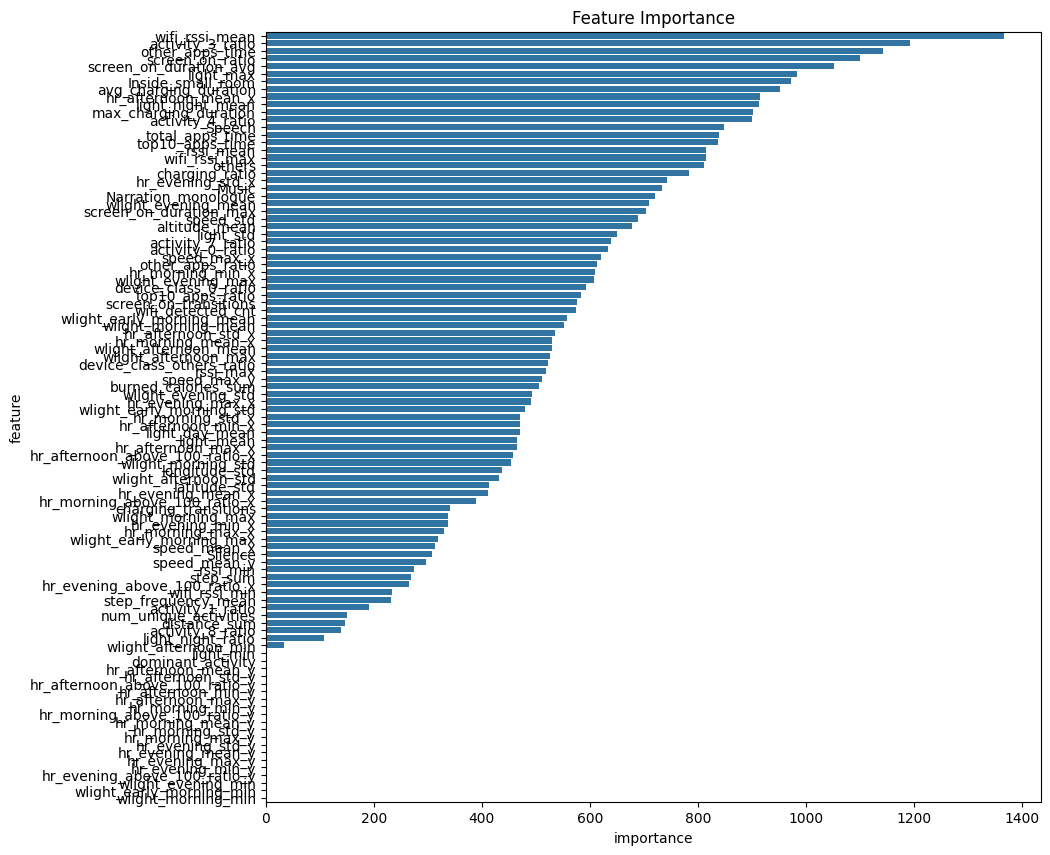

In [ ]:
# importance 출력
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model_s1.feature_importances_
}).sort_values('importance', ascending=False)

# 시각화
plt.figure(figsize=(18, 10))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [80]:
feature_importance[-1:-50:-1]

,feature,importance
67,hr_afternoon_min_y,0
75,hr_morning_std_y,0
76,hr_morning_max_y,0
77,hr_morning_min_y,0
78,hr_morning_above_100_ratio_y,0
32,light_min,0
66,hr_afternoon_max_y,0
65,hr_afternoon_std_y,0
68,hr_afternoon_above_100_ratio_y,0
64,hr_afternoon_mean_y,0


- wifi가 중요하다????

# 결과 예측 및 제출파일 저장

In [ ]:
# sample 기반 제출 포맷 가져오기
submission_final = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# lifelog_date 기준으로 string → date 형식 통일
submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

# ID 만들기 (submission에서 예측한 결과와 연결하기 위해)
submission_final['ID'] = submission_final['subject_id'] + '_' + submission_final['lifelog_date'].astype(str)

# 예측 결과 연결할 수 있도록 동일한 순서로 정렬
# 보통 예측 결과는 test_df 기준이므로 정렬 보장되어야 함
assert len(submission_final) == len(multiclass_pred)  # shape 체크

# 다중 분류 예측 붙이기
submission_final['S1'] = multiclass_pred

# 이진 분류 결과 붙이기
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    submission_final[col] = binary_preds[col].astype(int)  # 확률 아닌 class 예측

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# 저장
submission_final.to_csv("submission1.csv", index=False)

from google.colab import files
files.download("submission1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submission_final.shape

(250, 9)

In [ ]:
sample_submission.shape

(250, 9)

In [ ]:
submission_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subject_id    250 non-null    object
 1   sleep_date    250 non-null    object
 2   lifelog_date  250 non-null    object
 3   Q1            250 non-null    int64 
 4   Q2            250 non-null    int64 
 5   Q3            250 non-null    int64 
 6   S1            250 non-null    int64 
 7   S2            250 non-null    int64 
 8   S3            250 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 17.7+ KB


## TEST2: threshold 설정
- TEST3: 결측치 선형보간

In [100]:
#  타겟 리스트
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3']
target_multiclass = 'S1'

#  feature 준비
X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3'])
test_X = test_df.drop(columns=['subject_id', 'date'])

# 결측값 처리 - 선형 보간 (중간값만 보간)
X.fillna(0, inplace=True)
test_X.fillna(0, inplace=True)

# 컬럼 이름에서 특수 문자 제거/변환
def sanitize_column_names(df):
    df.columns = (
        df.columns
        .str.replace(r"[^\w]", "_", regex=True)  # 특수문자 → _
        .str.replace(r"__+", "_", regex=True)    # 연속된 _ 제거
        .str.strip("_")                          # 앞뒤 _ 제거
    )
    return df

# 모든 입력에 적용
X = sanitize_column_names(X)
test_X = sanitize_column_names(test_X)


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# threshold 설정
threshold = 0.4

# 결과 저장
binary_preds_threshold = {}
multiclass_pred = None

common_params = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

# 이진 분류: Train/Validation 나누고 평가 + 예측
for col in targets_binary:
    print(f"{col} 학습 시작")

    y = train_df[col]

    # 1. train/val split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 2. 학습
    model = LGBMClassifier(**common_params)
    model.fit(X_train, y_train)

    # 3. validation 평가
    val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    print(f" {col} Validation Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    # 4. test 데이터 예측 (확률)
    proba = model.predict_proba(test_X)[:, 1]

    # 5. threshold 적용
    pred = (proba >= threshold).astype(int)

    binary_preds_threshold[col] = pred

#  다중 분류 학습 (S1)
print(f"다중 분류 {target_multiclass} 학습 시작")

y_multi = train_df[target_multiclass]

X_train, X_val, y_train, y_val = train_test_split(
    X, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

model_s1 = LGBMClassifier(**common_params, objective='multiclass', num_class=3)
model_s1.fit(X_train, y_train)

val_pred = model_s1.predict(X_val)
acc = accuracy_score(y_val, val_pred)
f1 = f1_score(y_val, val_pred, average='macro')  # 다중분류는 macro F1
print(f"{target_multiclass} Validation Accuracy: {acc:.4f}, Macro F1 Score: {f1:.4f}")

multiclass_pred = model_s1.predict(test_X)

Q1 학습 시작
 Q1 Validation Accuracy: 0.4889, F1 Score: 0.4889
Q2 학습 시작
 Q2 Validation Accuracy: 0.5556, F1 Score: 0.5918
Q3 학습 시작
 Q3 Validation Accuracy: 0.6111, F1 Score: 0.6957
S2 학습 시작
 S2 Validation Accuracy: 0.6667, F1 Score: 0.7619
S3 학습 시작
 S3 Validation Accuracy: 0.6778, F1 Score: 0.7642
다중 분류 S1 학습 시작
S1 Validation Accuracy: 0.4778, Macro F1 Score: 0.3897


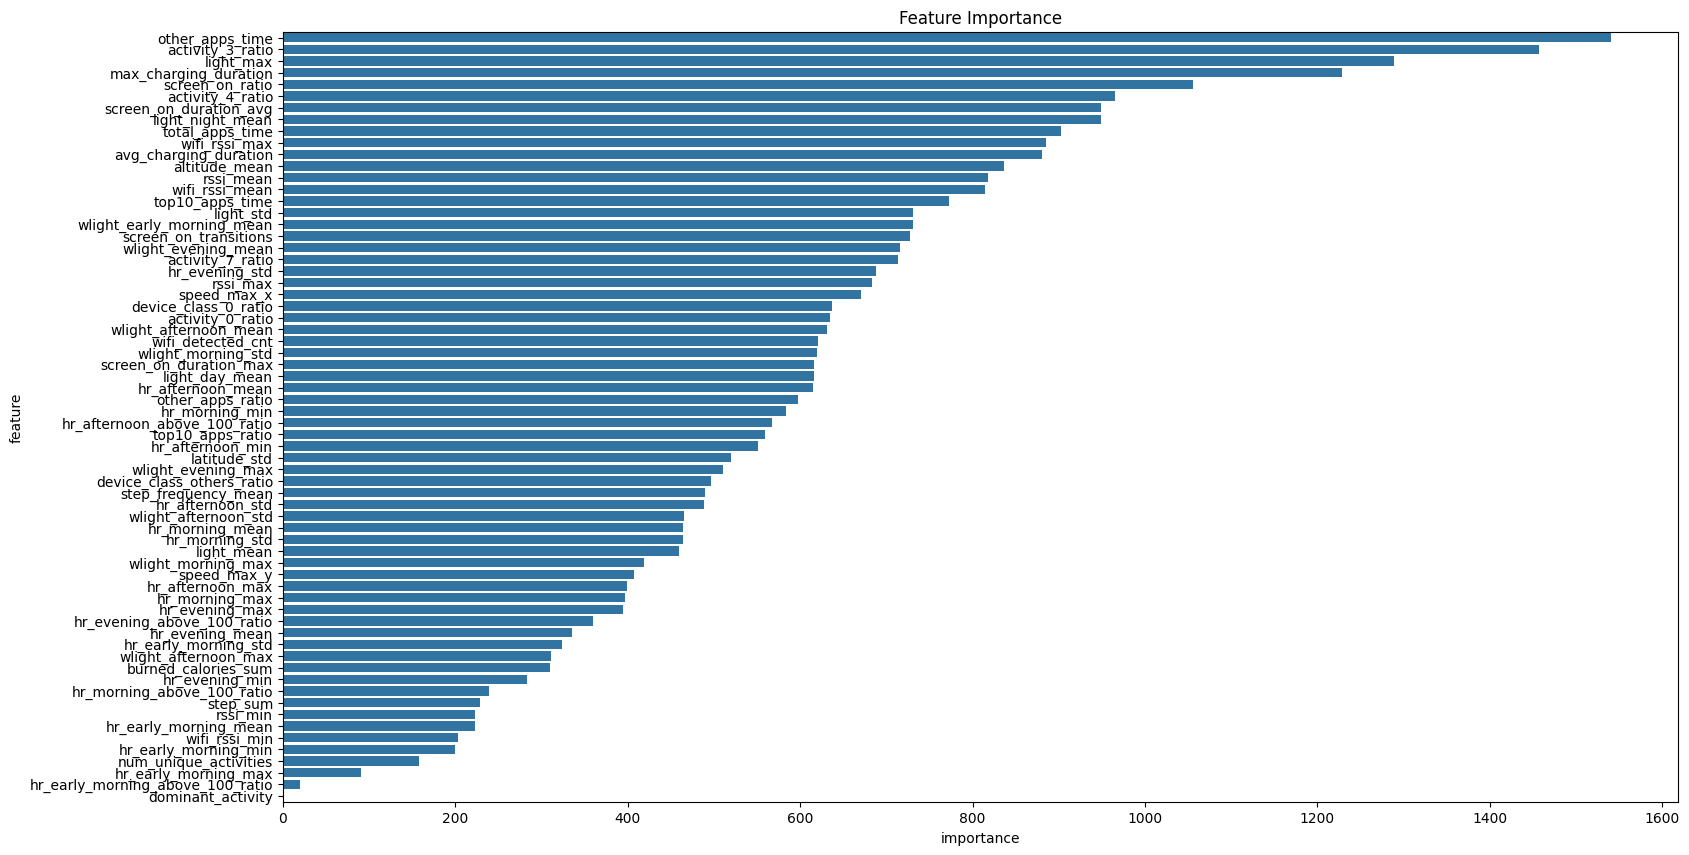

In [102]:
# importance 출력
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model_s1.feature_importances_
}).sort_values('importance', ascending=False)

# 시각화
plt.figure(figsize=(18, 10))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [103]:
# ✅ 제출 파일 작성
submission_final2 = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# 날짜형 변환
submission_final2['lifelog_date'] = pd.to_datetime(submission_final2['lifelog_date']).dt.date

# ID 만들기 (순서 일치 확인용)
submission_final2['ID'] = submission_final2['subject_id'] + '_' + submission_final2['lifelog_date'].astype(str)

# 테스트 개수 일치 체크
assert len(submission_final2) == len(multiclass_pred)

# 예측값 채우기
submission_final2['S1'] = multiclass_pred
for col in targets_binary:
    submission_final2[col] = binary_preds_threshold[col].astype(int)

# 컬럼 순서 정리
submission_final2 = submission_final2[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# CSV 저장
submission_final2.to_csv('submission5.csv', index=False)
print("저장 완료")

# 다운로드
from google.colab import files
files.download('submission5.csv')

저장 완료


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  CNN+LSTM 결합
- optimizer: Adam

### input 데이터 생성

In [168]:
# metrics_train에는 subject_id, lifelog_date, Q1~S3이 있을 것

# lifelog_date를 date로 통일
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date

# 이름 맞춰서 merge
merged_df = pd.merge(
    merged_df,
    metrics_train.rename(columns={'lifelog_date': 'date'}),
    on=['subject_id', 'date'],
    how='left'  # 라벨 없는 것도 남겨둠
)

In [169]:
from tqdm import tqdm

# 설정
SEQUENCE_LENGTH = 7  # 고정하고 싶은 시퀀스 길이 (ex: 최근 7일)

# feature 컬럼 리스트
feature_cols = [col for col in merged_df.columns if col not in ['subject_id', 'date', 'sleep_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

X_seq = []
y_target = []

grouped = merged_df.groupby('subject_id')

for subject_id, group in tqdm(grouped, desc="Subject별 시계열 생성"):
    group = group.sort_values('date')

    feature_seq = group[feature_cols].values  # (날짜 수, feature 수)

    # 🔥 시퀀스 길이를 고정: 최근 SEQUENCE_LENGTH일만 사용
    if len(feature_seq) >= SEQUENCE_LENGTH:
        feature_seq = feature_seq[-SEQUENCE_LENGTH:]
    else:
        # 🔥 부족하면 0으로 padding
        pad_width = ((SEQUENCE_LENGTH - len(feature_seq), 0), (0, 0))  # (앞에 패딩, 0)
        feature_seq = np.pad(feature_seq, pad_width=pad_width, mode='constant', constant_values=0)

    X_seq.append(feature_seq)

    # 라벨은 첫 번째 행 기준 (Q1~S3)
    label = group[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].iloc[0].values
    y_target.append(label)

# numpy array 변환
X_seq = np.stack(X_seq)  # (subject 수, SEQUENCE_LENGTH, feature 수)
y_target = np.stack(y_target)  # (subject 수, 6개 라벨)



Subject별 시계열 생성: 100%|██████████| 10/10 [00:00<00:00, 657.11it/s]


In [170]:
X_seq.shape

(10, 7, 66)

In [171]:
y_target.shape

(10, 6)

In [ ]:
#!pip install tensorflow

In [187]:
print(np.isnan(X_seq).sum())

0


In [173]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# 결측지 보정: 일단 0으로
X_seq = np.nan_to_num(X_seq, nan=0)

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_target, test_size=0.2, random_state=42)

# cnn+rnn
def build_cnn_lstm_model_bn(X_seq):
    input_shape = (X_seq.shape[1], X_seq.shape[2])  # (timesteps, features)
    inp = Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv1D(64, kernel_size=5, strides=1, padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)  # 🔥 첫 번째 pooling

    # Conv Block 2
    x = layers.Conv1D(128, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)  # 🔥 두 번째 pooling

    # Conv Block 3
    x = layers.Conv1D(256, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # LSTM
    x = layers.LSTM(128, return_sequences=False)(x)

    # Dense Layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Output Heads
    out_q1 = layers.Dense(1, activation='sigmoid', name='Q1')(x)
    out_q2 = layers.Dense(1, activation='sigmoid', name='Q2')(x)
    out_q3 = layers.Dense(1, activation='sigmoid', name='Q3')(x)
    out_s1 = layers.Dense(3, activation='softmax', name='S1')(x)
    out_s2 = layers.Dense(1, activation='sigmoid', name='S2')(x)
    out_s3 = layers.Dense(1, activation='sigmoid', name='S3')(x)

    model = models.Model(inputs=inp, outputs=[out_q1, out_q2, out_q3, out_s1, out_s2, out_s3])
    return model


model = build_cnn_lstm_model_bn(X_seq)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 7, 66)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 7, 64)          │         21,184 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 7, 64)          │            256 │ conv1d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 7, 64)          │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_11          │ (None, 3, 64)          │              0 │ activation_15[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 3, 128)         │         24,704 │ max_pooling1d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 3, 128)         │            512 │ conv1d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 3, 128)         │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_12          │ (None, 1, 128)         │              0 │ activation_16[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 1, 256)         │         98,560 │ max_pooling1d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 1, 256)         │          1,024 │ conv1d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 1, 256)         │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 128)            │        197,120 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │         33,024 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 256)            │          1,024 │ dense_10[0][0]         │
│ (BatchNormalization) 

 Total params: 411,848 (1.57 MB)

 Trainable params: 410,184 (1.56 MB)

 Non-trainable params: 1,664 (6.50 KB)

### 모델 학습

In [175]:
# early_stop 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # LR을 1/2로 줄임
    patience=5,   # 5번 개선 없으면 줄임
    verbose=1
)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'Q1': 'binary_crossentropy',
        'Q2': 'binary_crossentropy',
        'Q3': 'binary_crossentropy',
        'S1': 'sparse_categorical_crossentropy',
        'S2': 'binary_crossentropy',
        'S3': 'binary_crossentropy',
    },
    metrics={
        'Q1': 'accuracy',
        'Q2': 'accuracy',
        'Q3': 'accuracy',
        'S1': 'accuracy',
        'S2': 'accuracy',
        'S3': 'accuracy'
    }
)

# 모델 학습
history = model.fit(
    X_train, {
        'Q1': y_train[:, 0],
        'Q2': y_train[:, 1],
        'Q3': y_train[:, 2],
        'S1': y_train[:, 3],
        'S2': y_train[:, 4],
        'S3': y_train[:, 5]
    },
    validation_data=(X_val, {
        'Q1': y_val[:, 0],
        'Q2': y_val[:, 1],
        'Q3': y_val[:, 2],
        'S1': y_val[:, 3],
        'S2': y_val[:, 4],
        'S3': y_val[:, 5]
    }),
    epochs=100,
    batch_size=32,
    shuffle=False,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Q1_accuracy: 0.5000 - Q1_loss: 0.8106 - Q2_accuracy: 0.7500 - Q2_loss: 1.6070 - Q3_accuracy: 0.2500 - Q3_loss: 1.0700 - S1_accuracy: 0.5000 - S1_loss: 1.5656 - S2_accuracy: 0.7500 - S2_loss: 0.6572 - S3_accuracy: 0.5000 - S3_loss: 0.9764 - loss: 6.6869 - val_Q1_accuracy: 0.0000e+00 - val_Q1_loss: 0.7702 - val_Q2_accuracy: 0.5000 - val_Q2_loss: 0.6976 - val_Q3_accuracy: 0.5000 - val_Q3_loss: 0.7083 - val_S1_accuracy: 0.0000e+00 - val_S1_loss: 1.2951 - val_S2_accuracy: 1.0000 - val_S2_loss: 0.6695 - val_S3_accuracy: 1.0000 - val_S3_loss: 0.6114 - val_loss: 4.7521 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - Q1_accuracy: 0.3750 - Q1_loss: 1.1066 - Q2_accuracy: 0.5000 - Q2_loss: 1.2727 - Q3_accuracy: 0.5000 - Q3_loss: 0.6642 - S1_accuracy: 0.6250 - S1_loss: 1.1228 - S2_accuracy: 0.5000 - S2_loss: 1.0610 - S3_accuracy: 0.5000 - S3_loss: 1.0408 - loss: 6.2680 - val_Q1_accuracy: 0.0000e+00 - val_Q1_loss: 0.7

In [176]:
print("X_train min:", np.min(X_train))
print("X_train max:", np.max(X_train))
print("X_train mean:", np.mean(X_train))

print("y_train NaN 여부:", np.isnan(y_train).sum())
print("y_train 고유값:", np.unique(y_train))

X_train min: -104.0
X_train max: 56262350.0
X_train mean: 956829.2369072473
y_train NaN 여부: 0
y_train 고유값: [0. 1. 2.]


### 모델 예측 평가

In [177]:
# 전체 데이터 예측
y_pred = model.predict(X_seq)

# 이진 출력
binary_indices = [0, 1, 2, 4, 5]
y_pred_binary = [(y_pred[i] > 0.5).astype(int).reshape(-1) for i in binary_indices]
y_true_binary = [y_target[:, i] for i in binary_indices]

# 다중 분류 출력
y_pred_multiclass = np.argmax(y_pred[3], axis=1)
y_true_multiclass = y_target[:, 3]

# F1 점수 계산
f1s = [f1_score(y_true_binary[i], y_pred_binary[i], average='macro') for i in range(5)]
f1s.append(f1_score(y_true_multiclass, y_pred_multiclass, average='macro'))
macro_f1_total = np.mean(f1s)

print("📊 Macro F1 Score (전체 평균):", round(macro_f1_total, 5))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
📊 Macro F1 Score (전체 평균): 0.39213


In [178]:
y_pred_binary

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

### 제출 파일 생성

In [191]:
# 제출용 sample 불러오기
df_label = pd.read_csv("/content/ETRI/ch2025_submission_sample.csv")

# 날짜 포맷 맞추기
df_label['lifelog_date'] = pd.to_datetime(df_label['lifelog_date']).dt.date
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date

# feature 컬럼 지정
feature_cols = [col for col in merged_df.columns if col not in ['subject_id', 'date', 'sleep_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]
SEQUENCE_LENGTH = 7

# 제출용 시계열 생성
X_seq_submission = []

for _, row in tqdm(df_label.iterrows(), total=len(df_label)):
    subject_id = row['subject_id']
    lifelog_date = row['lifelog_date']

    # 🔥 해당 subject의, lifelog_date까지 7일 내역 가져오기
    subject_df = merged_df[(merged_df['subject_id'] == subject_id) & (merged_df['date'] <= lifelog_date)]
    subject_df = subject_df.sort_values('date')

    feature_seq = subject_df[feature_cols].values

    if len(feature_seq) >= SEQUENCE_LENGTH:
        feature_seq = feature_seq[-SEQUENCE_LENGTH:]
    else:
        pad_width = ((SEQUENCE_LENGTH - len(feature_seq), 0), (0, 0))  # 앞쪽 패딩
        feature_seq = np.pad(feature_seq, pad_width=pad_width, mode='constant', constant_values=0)

    X_seq_submission.append(feature_seq)

X_seq_submission = np.stack(X_seq_submission)

X_seq_submission = np.nan_to_num(X_seq_submission, nan=0)

print("✅ 제출용 시퀀스 shape:", X_seq_submission.shape)  # (250, 7, feature수)
print("✅ 제출용 NaN 개수:", np.isnan(X_seq_submission).sum())


#  모델로 제출용 예측하기
y_pred_submission = model.predict(X_seq_submission)

# 이진 분류 (Q1, Q2, Q3, S2, S3)
binary_indices = [0, 1, 2, 4, 5]
y_pred_binary_submission = [(y_pred_submission[i] > 0.4).astype(int).reshape(-1) for i in binary_indices]

# 다중 분류 (S1)
y_pred_multiclass_submission = np.argmax(y_pred_submission[3], axis=1)


# 제출 파일 작성
submission = df_label.copy()
submission['Q1'] = y_pred_binary_submission[0]
submission['Q2'] = y_pred_binary_submission[1]
submission['Q3'] = y_pred_binary_submission[2]
submission['S1'] = y_pred_multiclass_submission
submission['S2'] = y_pred_binary_submission[3]
submission['S3'] = y_pred_binary_submission[4]

#  필요 없는 컬럼 제거 (subject_id, sleep_date, lifelog_date만 남기기)
submission = submission[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

submission.to_csv("submission6.csv", index=False)

print(" 저장 완료")


100%|██████████| 250/250 [00:00<00:00, 900.22it/s]


✅ 제출용 시퀀스 shape: (250, 7, 66)
✅ 제출용 NaN 개수: 0
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
 저장 완료


In [192]:
submission.shape

(250, 9)

In [193]:
X_seq_submission

array([[[4.00000000e+01, 5.30000000e+01, 5.55555556e-02, ...,
         3.60790352e-02, 1.28483785e+00, 1.07939819e+02],
        [2.08666667e+01, 6.60000000e+01, 9.09722222e-02, ...,
         3.29309450e-02, 1.34135030e+00, 8.76998920e+01],
        [2.20588235e+01, 6.40000000e+01, 7.20279720e-02, ...,
         8.58695652e-02, 2.43149821e+00, 2.31849316e+02],
        ...,
        [5.73333333e+01, 1.05000000e+02, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.13333333e+01, 8.80000000e+01, 6.45833333e-02, ...,
         3.23267790e-02, 1.42821452e+00, 9.60797005e+01],
        [2.00588235e+01, 9.10000000e+01, 1.51388889e-01, ...,
         7.91857506e-02, 1.90083415e+00, 1.90789931e+02]],

       [[2.08666667e+01, 6.60000000e+01, 9.09722222e-02, ...,
         3.29309450e-02, 1.34135030e+00, 8.76998920e+01],
        [2.20588235e+01, 6.40000000e+01, 7.20279720e-02, ...,
         8.58695652e-02, 2.43149821e+00, 2.31849316e+02],
        [9.00000000e+00, 

In [194]:
for i in range(6):
    print(f"Output {i}: min={np.min(y_pred_submission[i])}, max={np.max(y_pred_submission[i])}, mean={np.mean(y_pred_submission[i])}")


Output 0: min=0.4482550621032715, max=0.4946453273296356, mean=0.4729519188404083
Output 1: min=0.42777562141418457, max=0.4909265339374542, mean=0.46359485387802124
Output 2: min=0.4736315608024597, max=0.5298781991004944, mean=0.5098869204521179
Output 3: min=0.2993984818458557, max=0.3634646534919739, mean=0.3333333432674408
Output 4: min=0.5531370043754578, max=0.5932155251502991, mean=0.569627046585083
Output 5: min=0.4616435170173645, max=0.5166227221488953, mean=0.48219916224479675


In [186]:
print(np.unique(y_train[:,0], return_counts=True))  # Q1
print(np.unique(y_train[:,1], return_counts=True))  # Q2
...


(array([0., 1.]), array([7, 1]))
(array([0., 1.]), array([3, 5]))


Ellipsis

In [190]:
print("X_seq_submission NaN 개수:", np.isnan(X_seq_submission).sum())


X_seq_submission NaN 개수: 14062
